<a href="https://colab.research.google.com/github/MatthewYancey/16-9GAN/blob/master/src/model_mse.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 16:9 Generative Model
This notebook takes images that are in a 4:3 aspect ratio and converts them to 16:9 aspect ratio.

## Imports and Parameters

In [1]:
import shutil
import glob
import random
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter

import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset
import torchvision.utils as vutils

from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
# network parameters
BATCH_SIZE = 30
DATASET_SIZE = 100000
N_BATCHES = (DATASET_SIZE // BATCH_SIZE) * 2 # divide by two because we have two data loaders and the batch size is split between them
N_GPU = 1
N_WORKERS = 1
N_EPOCHS = 100
LEARNING_RATE = 0.0002

# image
IMG_HEIGHT = 256
IMG_WIDTH = 455
SINGLE_SIDE = 57
# IMG_WIDTH = 256
# SINGLE_SIDE = 32

# directories
ZIP_PATH_TRAIN = '/content/gdrive/My Drive/16:9GAN/data_out/train.zip'
IMG_DIR_TRAIN = '/content/frames/train/'
ZIP_PATH_VAL = '/content/gdrive/My Drive/16:9GAN/data_out/validate.zip'
IMG_DIR_VAL = '/content/frames/validate/'
ZIP_PATH_TEST = '/content/gdrive/My Drive/16:9GAN/data_out/test.zip'
IMG_DIR_TEST = '/content/frames/test/'
LOG_DIR = '/content/gdrive/My Drive/16:9GAN/data_out/logs/model_001/'

# checkpoint type
CHECKPOINT_TYPE = 'none' # none or prev_checkpoint

In [3]:
# unzips images
shutil.unpack_archive(ZIP_PATH_TRAIN, IMG_DIR_TRAIN, 'zip')
shutil.unpack_archive(ZIP_PATH_VAL, IMG_DIR_VAL, 'zip')
shutil.unpack_archive(ZIP_PATH_TEST, IMG_DIR_TEST, 'zip')

In [4]:
# sets what device to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and N_GPU > 0) else "cpu")
print(f'Device: {device}')

Device: cuda:0


## Helper Functions

### Apply Mask

In [5]:
# helper function for apply the mask for cutting the frame to 4:3
def apply_mask(img_batch):
    if len(img_batch.shape) > 3:
        img_batch[:, :, :, (IMG_WIDTH - SINGLE_SIDE):] = -1
        img_batch[:, :, :, :SINGLE_SIDE] = -1
    else:
        img_batch[:, :, (IMG_WIDTH - SINGLE_SIDE):] = -1
        img_batch[:, :, :SINGLE_SIDE] = -1
    
    return img_batch

### Apply Padding

In [6]:
# adds -1 padding to the sides of images that are in 4:3 aspect ratio
def apply_padding(img):
    padding = torch.zeros([3, IMG_HEIGHT, SINGLE_SIDE])
    padding = padding.new_full((3, IMG_HEIGHT, SINGLE_SIDE), -1)
    img_cat = torch.cat((padding, image, padding), 2)

    return img_cat

### Apply Composite

In [7]:
def apply_comp(img, img_gen):
    if len(img.shape) > 3:
        comp_img = torch.cat((img_gen[:, :, :, :SINGLE_SIDE], 
                            img[:, :, :, SINGLE_SIDE:(IMG_WIDTH-SINGLE_SIDE)], 
                            img_gen[:, :, :, (IMG_WIDTH-SINGLE_SIDE):]), 3)
    else:
        comp_img = torch.cat((img_gen[:, :, :SINGLE_SIDE], 
                    img[:, :, SINGLE_SIDE:(IMG_WIDTH-SINGLE_SIDE)], 
                    img_gen[:, :, (IMG_WIDTH-SINGLE_SIDE):]), 2)

    return comp_img

### Image Scaling

In [8]:
# helper function for converting images to a normal range
def img_scale(img_tensor, plot=False):
    min_value = img_tensor.min()
    span = img_tensor.max() - img_tensor.min()
    img_tensor = (img_tensor - min_value) / span

    # tensorboard and matplotlib take images in different formats
    if plot:
        img_tensor = img_tensor.transpose(0, 2)
        img_tensor = torch.rot90(img_tensor, -1) # fixes a rotation issue

    return img_tensor

### Checkpoint

In [9]:
def checkpoint(epoch, i, batch_counter, disc_loss, train_loss, val_loss):
    print(f'Epoch: {epoch}/{N_EPOCHS}, Batch in Epoch: {i}/{N_BATCHES}, Total Images {batch_counter * BATCH_SIZE}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

    # saves everything once every epoch
    if i % 600 == 0:
        # saves loss to the tensorboard log
        writer = SummaryWriter(LOG_DIR)
        writer.add_scalar('Loss/Disc', disc_loss, batch_counter)
        writer.add_scalar('Loss/Train', train_loss, batch_counter)
        writer.add_scalar('Loss/Val', val_loss, batch_counter)

        # saves a checkpoint
        checkpoint = {'gen_state': gen.state_dict(), 
                        'gen_optimizer': optimizer_gen.state_dict()}
        torch.save(checkpoint, LOG_DIR + 'checkpoint.pt')

        # gets images from the dataloader
        train_image = dataloader_train.dataset.__getitem__(TRAIN_REFERENCE_INDEX)
        train_image = train_image.unsqueeze(0)
        train_image = train_image.cuda()
        train_image = img_scale(train_image)
        val_image = dataloader_val.dataset.__getitem__(VAL_REFERENCE_INDEX)
        val_image = val_image.unsqueeze(0)
        val_image = val_image.cuda()
        val_image = img_scale(val_image)
        test_image = dataloader_test.dataset.__getitem__(TEST_REFERENCE_INDEX)
        test_image = apply_padding(test_image)
        test_image = test_image.unsqueeze(0)
        test_image = test_image.cuda()
        test_image = img_scale(test_image)

        # if this is the first epoch we save the reference images
        if epoch == 0:
            print('Saving reference images')
            # training reference image
            writer.add_image(f'.Reference Train Image', train_image.squeeze(0))
            writer.add_image(f'.Reference Train Image Mask', apply_mask(train_image.squeeze(0)))
            # validation reference image
            writer.add_image(f'.Reference Validation Image', val_image.squeeze(0))
            writer.add_image(f'.Reference Validation Image Mask', apply_mask(val_image.squeeze(0)))
            # testing reference image
            writer.add_image(f'.Reference Test Image', test_image.squeeze(0))

        with torch.no_grad():
            _, train_image_gen = gen(apply_mask(train_image))
            _, val_image_gen = gen(apply_mask(val_image))
            _, test_image_gen = gen(test_image)

        train_image_gen = train_image_gen.squeeze(0)
        train_image_gen = img_scale(train_image_gen)
        train_image_gen = apply_comp(train_image.squeeze(0), train_image_gen)
        writer.add_image(f'batch_{batch_counter}_train', train_image_gen)

        val_image_gen = val_image_gen.squeeze(0)
        val_image_gen = img_scale(val_image_gen)
        val_image_gen = apply_comp(val_image.squeeze(0), val_image_gen)
        writer.add_image(f'batch_{batch_counter}_val', val_image_gen)

        test_image_gen = test_image_gen.squeeze(0)
        test_image_gen = img_scale(test_image_gen)
        test_image_gen = apply_comp(test_image.squeeze(0), test_image_gen)
        writer.add_image(f'batch_{batch_counter}_test', test_image_gen)

        # saves the epoch counter
        with open(LOG_DIR + '/itercount.txt', 'w') as f:
            f.write(str(batch_counter))
        
        writer.close()
        print('Saved checkpoint')

## Data Loaders

In [10]:
# a custom dataset class for reading in our images from the list
class ReadFromList(Dataset):
    def __init__(self, img_list, transform=None):
        self.img_list = img_list
        self.transform = transform

    def __len__(self):
        return len(self.img_list)

    def __getitem__(self, idx):
        image = Image.open(self.img_list[idx]).convert('RGB')
        if self.transform is not None:
            image = self.transform(image)

        return image

### Training Data

In [11]:
# gets the list of images
img_list = glob.glob(IMG_DIR_TRAIN + '*')
img_list.sort()
print(f'Number of images: {len(img_list)}')
img_list = img_list[:DATASET_SIZE]

# makes the dataset and data loader
dataset = ReadFromList(img_list, transform=transforms.Compose([
                                    # transforms.RandomHorizontalFlip(p=0.5),
                                    transforms.ToTensor(),
                                    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),]))

dataloader_train = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE//2, shuffle=True, num_workers=N_WORKERS)
print(f'Size of dataset: {len(dataloader_train.dataset)}')

Number of images: 114808
Size of dataset: 100000


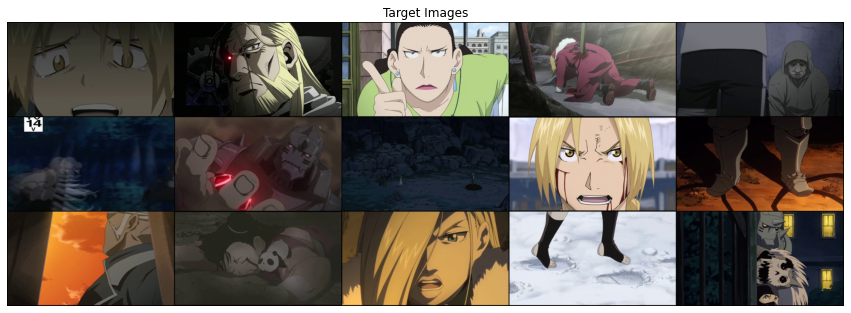

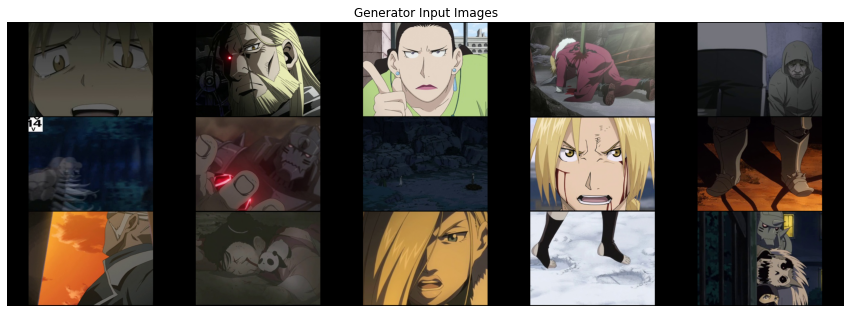

In [12]:
# Plot some training images
batch = next(iter(dataloader_train))

plt.figure(figsize=(15, 15))
plt.axis('off')
plt.title('Target Images')
plt.imshow(np.transpose(vutils.make_grid(batch.to(device)[:64], padding=2, normalize=True, nrow=5).cpu(),(1,2,0)))

batch = apply_mask(batch)

plt.figure(figsize=(15, 15))
plt.axis('off')
plt.title('Generator Input Images')
plt.imshow(np.transpose(vutils.make_grid(batch.to(device)[:64], padding=2, normalize=True, nrow=5).cpu(),(1,2,0)))

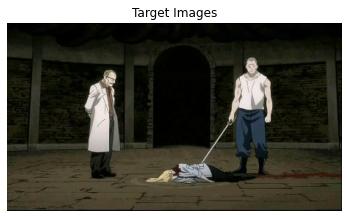

In [13]:
TRAIN_REFERENCE_INDEX = 200

image = dataloader_train.dataset.__getitem__(TRAIN_REFERENCE_INDEX)
image = img_scale(image)
plt.figure(figsize=(6, 6))
plt.axis('off')
plt.title('Target Images')
plt.imshow(np.transpose(vutils.make_grid(image).cpu(),(1,2,0)))

### Validation Data

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Number of images: 36734
Size of dataset: 36734


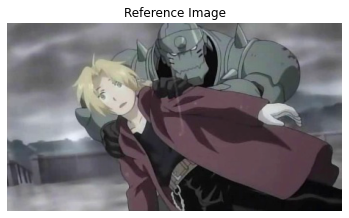

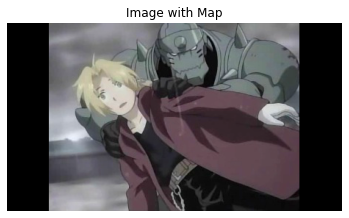

In [14]:
# gets the list of images
img_list = glob.glob(IMG_DIR_VAL + '*')
img_list.sort()
print(f'Number of images: {len(img_list)}')

# makes the dataset and data loader
dataset = ReadFromList(img_list, transform=transforms.Compose([
                                    # transforms.RandomHorizontalFlip(p=0.5),
                                    transforms.ToTensor(),
                                    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),]))

dataloader_val = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE//2, shuffle=True, num_workers=N_WORKERS)
print(f'Size of dataset: {len(dataloader_val.dataset)}')

# This is the testing reference image
VAL_REFERENCE_INDEX = 100
image = dataloader_val.dataset.__getitem__(VAL_REFERENCE_INDEX)
image = img_scale(image)

plt.figure(figsize=(6, 6))
plt.axis('off')
plt.title('Reference Image')
plt.imshow(np.transpose(vutils.make_grid(image).cpu(),(1,2,0)))

image = apply_mask(image)

plt.figure(figsize=(6, 6))
plt.axis('off')
plt.title('Image with Map')
plt.imshow(np.transpose(vutils.make_grid(image).cpu(),(1,2,0)))

### Test Data

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Number of images: 2210
Size of dataset: 2210


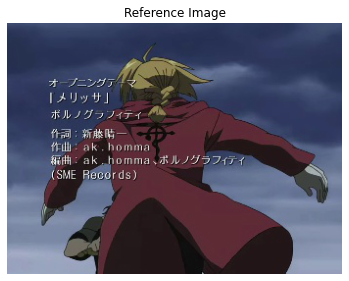

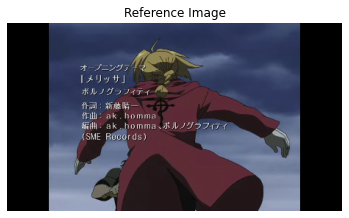

In [15]:
# gets the list of images
img_list = glob.glob(IMG_DIR_TEST + '*')
img_list.sort()
print(f'Number of images: {len(img_list)}')

# makes the dataset and data loader
dataset = ReadFromList(img_list, transform=transforms.Compose([
                                    # transforms.RandomHorizontalFlip(p=0.5),
                                    transforms.ToTensor(),
                                    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),]))

dataloader_test = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE//2, shuffle=True, num_workers=N_WORKERS)
print(f'Size of dataset: {len(dataloader_test.dataset)}')

# This is the testing reference image
TEST_REFERENCE_INDEX = 20
image = dataloader_test.dataset.__getitem__(TEST_REFERENCE_INDEX)
image = img_scale(image)

plt.figure(figsize=(6, 6))
plt.axis('off')
plt.title('Reference Image')
plt.imshow(np.transpose(vutils.make_grid(image, padding=2, nrow=4).cpu(),(1,2,0)))

img_cat = apply_padding(image)

plt.figure(figsize=(6, 6))
plt.axis('off')
plt.title('Reference Image')
plt.imshow(np.transpose(vutils.make_grid(img_cat, padding=2, nrow=4).cpu(),(1,2,0)))

## Networks

### Generartor

In [16]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [17]:
class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()

        self.conv1 = nn.Conv2d(3, 64, kernel_size=5, stride=1, padding=1, bias=False)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1, bias=False)
        self.conv3 = nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1, bias=False)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1, bias=False)
        self.conv5 = nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1, bias=False)
        self.conv6 = nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1, bias=False)
        
        self.dilconv1 = nn.Conv2d(256, 256, kernel_size=3, stride=1, dilation=2, padding=2)
        self.dilconv2 = nn.Conv2d(256, 256, kernel_size=3, stride=1, dilation=4, padding=4)
        self.dilconv3 = nn.Conv2d(256, 256, kernel_size=3, stride=1, dilation=8, padding=8)
        self.dilconv4 = nn.Conv2d(256, 256, kernel_size=3, stride=1, dilation=16, padding=16)

        self.conv7 = nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1, bias=False)
        self.conv8 = nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1, bias=False)

        self.deconv1 = nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1)
        self.conv9 = nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1, bias=False)
        
        self.deconv2 = nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1)
        self.conv10 = nn.Conv2d(64, 32, kernel_size=3, stride=1, padding=1, bias=False)
        
        self.conv11 = nn.Conv2d(32, 3, kernel_size=3, stride=1, padding=1, bias=False)

        self.batch_norm3 = nn.BatchNorm2d(3)
        self.batch_norm32 = nn.BatchNorm2d(32)
        self.batch_norm64 = nn.BatchNorm2d(64)
        self.batch_norm128 = nn.BatchNorm2d(128)
        self.batch_norm256 = nn.BatchNorm2d(256)

        self.relu = nn.ReLU()
        self.tanh = nn.Tanh()

    def forward(self, img):
        # encoding
        x = self.conv1(img)
        x = self.batch_norm64(x)
        x = self.relu(x)

        x = self.conv2(x)
        x = self.batch_norm128(x)
        x = self.relu(x)

        x = self.conv3(x)
        x = self.batch_norm128(x)
        x = self.relu(x)
        
        x = self.conv4(x)
        x = self.batch_norm256(x)
        x = self.relu(x)

        x = self.conv5(x)
        x = self.batch_norm256(x)
        x = self.relu(x)

        x = self.conv6(x)
        x = self.batch_norm256(x)
        x = self.relu(x)

        # dilation
        x = self.dilconv1(x)
        x = self.batch_norm256(x)
        x = self.relu(x)        

        x = self.dilconv2(x)
        x = self.batch_norm256(x)
        x = self.relu(x)        

        x = self.dilconv3(x)
        x = self.batch_norm256(x)
        x = self.relu(x)        

        x = self.dilconv4(x)
        x = self.batch_norm256(x)
        x = self.relu(x)        

        # more encoding
        x = self.conv7(x)
        x = self.batch_norm256(x)
        x = self.relu(x)

        x = self.conv8(x)
        x = self.batch_norm256(x)
        x = self.relu(x)

        # decoding
        x = self.deconv1(x)
        x = self.batch_norm128(x)
        x = self.relu(x)

        x = self.conv9(x)
        x = self.batch_norm128(x)
        x = self.relu(x)

        x = self.deconv2(x)
        x = self.batch_norm64(x)
        x = self.relu(x)

        x = self.conv10(x)
        x = self.batch_norm32(x)
        x = self.relu(x)

        # output
        x = self.conv11(x)
        x = self.tanh(x)

        # creates the local output and global output that is combined with the orginal image
        gen_output_local = x[:, :, :, (IMG_WIDTH - SINGLE_SIDE):]
        global_gen_output = x

        return (gen_output_local, x)

## Training

### Initialize the Networks

In [18]:
gen = Generator(N_GPU).to(device)
gen.apply(weights_init)

Generator(
  (conv1): Conv2d(3, 64, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1), bias=False)
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (conv3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (conv5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (conv6): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (dilconv1): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2), dilation=(2, 2))
  (dilconv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(4, 4), dilation=(4, 4))
  (dilconv3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(8, 8), dilation=(8, 8))
  (dilconv4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(16, 16), dilation=(16, 16))
  (conv7): Conv2d(256, 256, kernel_size=(3, 3),

### Loss Function and Optimizer

In [19]:
loss = nn.BCELoss()
mse_loss = nn.MSELoss()
optimizer_gen = optim.Adam(gen.parameters(), lr=LEARNING_RATE, betas=(0.5, 0.9))

### Loads Checkpoints

In [20]:
if CHECKPOINT_TYPE == 'prev_checkpoint':
    # loads the model weights
    saved_checkpoint = torch.load(LOG_DIR + 'checkpoint.pt')
    gen.load_state_dict(saved_checkpoint['gen_state'])
    optimizer_gen.load_state_dict(saved_checkpoint['gen_optimizer'])
    print('Checkpoint Loaded')
    
    # loads the epoch counter
    with open(LOG_DIR + 'itercount.txt', 'r') as f:
        batch_counter = int(f.read())
    # moves it up one becuase it's currenlty at the last epoch we did
    batch_counter += 1

elif CHECKPOINT_TYPE == 'none':
    # remove all previous logs
    try:
        shutil.rmtree(LOG_DIR)
        print('Folders removed')
    except FileNotFoundError:
        print('No log folder found')

    batch_counter = 1

else:
    print('Failed to specify a type')

Folders removed


### Training Loop

In [ ]:
for epoch in range(N_EPOCHS):
    # gets data for the generator
    for i, batch in enumerate(dataloader_train, 0):

        # generater
        gen.zero_grad()
        batch_mask = batch.clone()
        batch_mask = apply_mask(batch_mask)
        _, gen_output_global = gen(batch_mask.to(device))

        # keeps only the edges from the generator and calculates the loss
        gen_output_global = apply_comp(batch.to(device), gen_output_global)
        train_loss = mse_loss(gen_output_global, batch.to(device))
        
        # error and optimize
        train_loss.backward()
        optimizer_gen.step()

        # checkpoints and print statistics every n batches
        if i % 10 == 0:
            # gets the testing MSE
            batch = next(iter(dataloader_val))
            batch_mask = batch.clone()
            batch_mask = apply_mask(batch_mask)
            with torch.no_grad():
                _, gen_output_global = gen(batch_mask.to(device))
            gen_output_global = apply_comp(batch.to(device), gen_output_global)

            val_loss = mse_loss(gen_output_global, batch.to(device))
            checkpoint(epoch, i, batch_counter, 0, train_loss.item(), val_loss.item())

        batch_counter += 1

Epoch: 0/100, Batch in Epoch: 0/6666, Total Images 30, Train Loss: 0.1139, Val Loss: 0.0801
Saving reference images
Saved checkpoint
Epoch: 0/100, Batch in Epoch: 10/6666, Total Images 330, Train Loss: 0.0259, Val Loss: 0.0385
Epoch: 0/100, Batch in Epoch: 20/6666, Total Images 630, Train Loss: 0.0362, Val Loss: 0.0407
Epoch: 0/100, Batch in Epoch: 30/6666, Total Images 930, Train Loss: 0.0331, Val Loss: 0.0293
Epoch: 0/100, Batch in Epoch: 40/6666, Total Images 1230, Train Loss: 0.0207, Val Loss: 0.0385
Epoch: 0/100, Batch in Epoch: 50/6666, Total Images 1530, Train Loss: 0.0343, Val Loss: 0.0326
Epoch: 0/100, Batch in Epoch: 60/6666, Total Images 1830, Train Loss: 0.0226, Val Loss: 0.0607
Epoch: 0/100, Batch in Epoch: 70/6666, Total Images 2130, Train Loss: 0.0191, Val Loss: 0.0481
Epoch: 0/100, Batch in Epoch: 80/6666, Total Images 2430, Train Loss: 0.0351, Val Loss: 0.0455
Epoch: 0/100, Batch in Epoch: 90/6666, Total Images 2730, Train Loss: 0.0291, Val Loss: 0.0276
Epoch: 0/100, B